In [182]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error


Step 1: download wheat price data

In [640]:
# https://www.nasdaq.com/market-activity/commodities/zw/historical?page=1&rows_per_page=10&timeline=y5
# https://www.cmegroup.com/markets/agriculture/grains/wheat.html

# US$ cents per bushel
# 5k bushels per contract
wheat_prices = pd.read_csv('wheat_historical_data.csv')
wheat_prices.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,06/07/2024,627.50,118856,639.50,639.50,618.25
1,06/06/2024,639.50,78701,649.75,654.00,638.25
2,06/05/2024,646.75,79122,659.25,664.25,642.75
3,06/04/2024,658.25,77793,672.50,681.25,657.75
4,06/03/2024,672.75,80772,678.00,697.75,667.50
5,05/31/2024,678.50,51136,680.50,691.50,673.75
6,05/30/2024,681.00,65871,682.25,685.00,673.25
7,05/29/2024,692.75,60524,701.50,706.25,688.50
8,05/28/2024,700.25,68850,713.00,720.00,693.75
9,05/24/2024,697.25,65113,701.25,706.00,689.00


In [641]:
wheat_prices['datetime'] = pd.to_datetime(wheat_prices['Date'], format='%m/%d/%Y')
wheat_prices = wheat_prices.set_index('datetime')
wheat_prices['price'] = wheat_prices['Close/Last']
wheat_prices = wheat_prices[['price']].sort_index()

<Axes: xlabel='datetime'>

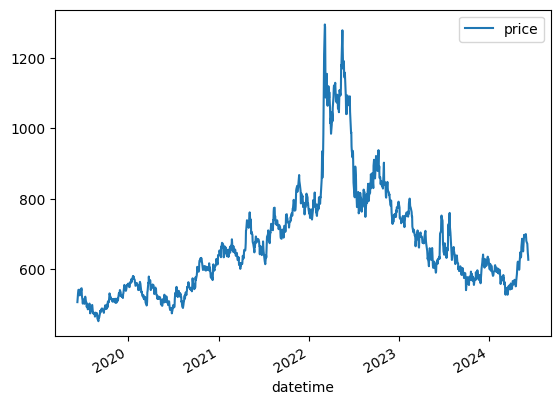

In [642]:
wheat_prices.plot()

array([[<Axes: title={'center': 'price'}>]], dtype=object)

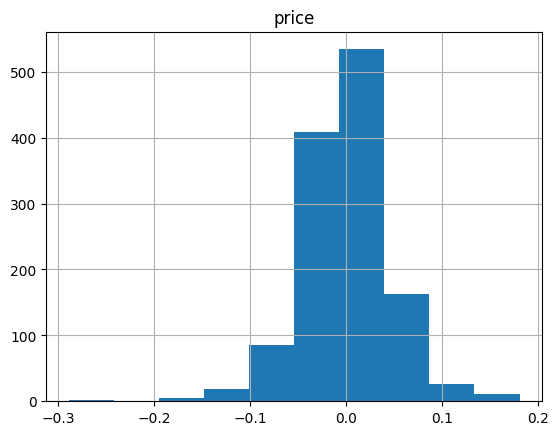

In [186]:
wheat_prices.pct_change(5).dropna().hist()

Step 2: build some features to form a dataset

In [187]:
# we will build features using precipitations data, 
# temperature data and simple technical indicators
# the target will be weekly returns
historical_temperatures = pd.read_parquet('historical_temperatures.parquet')
historical_precipitations = pd.read_parquet('historical_precipitations.parquet')

In [188]:
# https://www.procurementresource.com/blog/wheat-producing-regions-in-the-usa
relevant_states = ['ND', 'KS', 'WA', 'MT', 'ID']
historical_temperatures = historical_temperatures.loc[historical_temperatures['state'].isin(relevant_states)]
historical_precipitations = historical_precipitations.loc[historical_precipitations['state'].isin(relevant_states)]

In [189]:
# just my guess!
historical_temperatures = historical_temperatures.loc[historical_temperatures['elevation'] < 1000]
historical_precipitations = historical_precipitations.loc[historical_precipitations['elevation'] < 1000]

In [190]:
historical_temperatures['TMAX_diff_365'] = historical_temperatures.groupby('id')['TMAX'].diff(365)
tmax_diff_365_by_state = historical_temperatures.groupby(['datetime', 'state'])['TMAX_diff_365'].mean().unstack()

historical_temperatures['TMIN_diff_365'] = historical_temperatures.groupby('id')['TMIN'].diff(365)
tmin_diff_365_by_state = historical_temperatures.groupby(['datetime', 'state'])['TMIN_diff_365'].mean().unstack()


historical_precipitations['precip_diff_365'] = historical_precipitations.groupby('id')['no_info'].diff(365)
precip_diff_365_by_state = historical_precipitations.groupby(['datetime', 'state'])['precip_diff_365'].mean().unstack()

In [811]:
target = wheat_prices.pct_change(5).shift(-5).dropna().sort_index()

In [812]:
dataset = target.join(
    tmax_diff_365_by_state, how='left').join(tmin_diff_365_by_state, how='left', rsuffix='_temp_min', lsuffix='_temp_max').join(
        tmin_diff_365_by_state, how='left'
    ).dropna()

In [813]:
dataset = target.join(
    pd.DataFrame({'temperature': ((historical_temperatures['TMAX'] + historical_temperatures['TMIN']) / 2).unstack().mean(axis=1).diff(365)})
).join(
    pd.DataFrame({'precipitation': historical_precipitations['no_info'].unstack().mean(axis=1).diff(365)})
                  ).dropna()

In [814]:
dataset = dataset['2021-01-02':]

In [815]:
dataset

,price,temperature,precipitation
datetime,,,
2021-01-04,-0.011293,4.937093,-56.254291
2021-01-05,0.016820,3.606531,-7.103227
2021-01-06,0.020077,2.467434,18.976717
2021-01-07,0.043207,0.348497,-32.143093
2021-01-08,0.057534,-1.850710,-92.859437
...,...,...,...
2024-05-24,-0.035138,-0.488794,19.603311
2024-05-28,-0.059979,3.201306,-7.385679
2024-05-29,-0.066402,2.145268,-8.235971


In [816]:
end_in_sample_date = '2023-06-30'
start_out_of_sample_date = '2023-10-01'

In [817]:
dataset[:end_in_sample_date].corr()

,price,temperature,precipitation
price,1.000000,0.021732,0.010354
temperature,0.021732,1.000000,0.090731
precipitation,0.010354,0.090731,1.000000


Step 3: fit the model

In [818]:
# we will try to predict the raw returns first (regression)
# and then the binned returns 
# (i.e. bin 1 = negative returns, bin 2 = around zero, bin 3 = positive returns)
# we will use an xgboost and a linear regression as a benchmark

In [819]:
X = dataset.drop(columns='price')
y = dataset['price'].copy()

In [820]:
#idx_pos = y > 0.02
#idx_neg = y < - 0.02
#
#y.loc[:] = 1
#y.loc[idx_pos] = 2
#y.loc[idx_neg] = 0
#
#y = y.astype(int)

y = (y > 0).astype(int)

In [821]:
X_train = X[:end_in_sample_date].copy()
X_test = X[start_out_of_sample_date:].copy()
y_train = y[:end_in_sample_date].copy()
y_test = y[start_out_of_sample_date:].copy()


In [822]:
from sklearn.neural_network import MLPClassifier, MLPRegressor


In [823]:
regr = MLPClassifier(random_state=1, max_iter=5000, hidden_layer_sizes=(10, 10, 10)).fit(X_train, y_train)

y_pred = regr.predict(X_test.dropna())

In [824]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [825]:
y_test.values

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [826]:
#mean_squared_error(y_test, y_pred)

In [827]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.76      0.58        78
           1       0.54      0.24      0.34        90

    accuracy                           0.48       168
   macro avg       0.50      0.50      0.46       168
weighted avg       0.50      0.48      0.45       168

